In [1]:
# Install required packages
!pip install torch torchvision torchaudio

import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

!pip install pennylane torch torch-geometric qiskit

Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
  Using cached https://data.pyg.org/whl/torch-2.8.0%2Bcu126/torch_scatter-2.1.2%2Bpt28cu126-cp312-cp312-linux_x86_64.whl (10.9 MB)
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
  Using cached https://data.pyg.org/whl/torch-2.8.0%2Bcu126/torch_sparse-0.6.18%2Bpt28cu126-cp312-cp312-linux_x86_64.whl (5.2 MB)
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
  Using cached https://data.pyg.org/whl/torch-2.8.0%2Bcu126/torch_cluster-1.6.3%2Bpt28cu126-cp312-cp312-linux_x86_64.whl (3.3 MB)
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-4uydpixv
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-4uydpixv
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit aae8bd25021f2f09c8919e752dd361f6dd997cd9
  Installing build dependencies ... done
  Getting requirements to build wh

In [2]:
pip install xgboost cuml-cu12 --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [3]:
pip install node2vec gensim

In [4]:
import pickle
import networkx as nx
import numpy as np
import random

# Load the graph
with open('/content/drive/MyDrive/dataset/MulDiGraph.pkl', 'rb') as f:
    G = pickle.load(f)
    print("Graph read successfully")

# Extract fraud and non-fraud nodes
fraud_nodes = [node for node in G.nodes if G.nodes[node]['isp'] == 1]
normal_nodes = [node for node in G.nodes if G.nodes[node]['isp'] == 0]
print(f"Fraud nodes: {len(fraud_nodes)}, Non-fraud nodes: {len(normal_nodes)}")

# Select all fraud nodes and a larger random sample of non-fraud nodes
random.seed(42)
selected_fraud = fraud_nodes
selected_normal = random.sample(normal_nodes, 10000)  # Larger sample
selected_nodes = set(selected_fraud + selected_normal)

# Expand the graph by collecting neighbors iteratively
def expand_with_neighbors(G, node_set, max_nodes=50000):
    visited = set(node_set)
    frontier = list(node_set)
    i = 0
    while len(visited) < max_nodes and i < len(frontier):
        node = frontier[i]
        neighbors = set(G.predecessors(node)) | set(G.successors(node))
        for neighbor in neighbors:
            if neighbor not in visited:
                visited.add(neighbor)
                frontier.append(neighbor)
        i += 1
    return visited

final_nodes = expand_with_neighbors(G, selected_nodes, max_nodes=50000)

# Create the subgraph
subgraph2 = G.subgraph(final_nodes).copy()
print(f"Final Subgraph - Nodes: {subgraph2.number_of_nodes()}, Edges: {subgraph2.number_of_edges()}")

Graph read successfully
Fraud nodes: 1165, Non-fraud nodes: 2972324
Final Subgraph - Nodes: 54911, Edges: 1721354


Class Distribution in Subgraph:
Class 0: 53746 nodes
Class 1: 1165 nodes


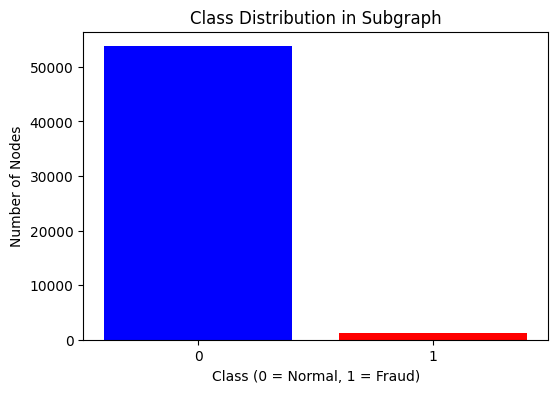

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Extract class labels from the subgraph
class_labels = np.array([subgraph2.nodes[node]['isp'] for node in subgraph2.nodes])

# Count occurrences of each class
unique, counts = np.unique(class_labels, return_counts=True)

# Print the distribution
print("Class Distribution in Subgraph:")
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} nodes")

# Plot class distribution
plt.figure(figsize=(6, 4))
plt.bar(unique.astype(str), counts, color=['blue', 'red'])
plt.xlabel("Class (0 = Normal, 1 = Fraud)")
plt.ylabel("Number of Nodes")
plt.title("Class Distribution in Subgraph")
plt.show()

In [6]:
# Print all attributes for a specific node
node = list(subgraph2.nodes())[0]  # Pick first node
print(f"Attributes of node {node}: {subgraph2.nodes[node]}")
# Print all attributes for a specific edge
edge = list(subgraph2.edges(keys=True))[0]  # Pick first edge (u, v, key)
print(f"Attributes of edge {edge}: {subgraph2.edges[edge]}")

Attributes of node 0x2d9e1340dc00e520387daeddbbca17daa5a300c0: {'isp': 0}
Attributes of edge ('0x2d9e1340dc00e520387daeddbbca17daa5a300c0', '0xaef38fbfbf932d1aef3b808bc8fbd8cd8e1f8bc5', 0): {'amount': 0.0, 'timestamp': 1492072011.0}


In [7]:
import networkx as nx

# Step 1: Assign edge weights
for u, v, key, attrs in subgraph2.edges(keys=True, data=True):
    amount = attrs.get("amount", 0)  # Default weight = 0 if amount is missing
    subgraph2[u][v][key]["weight"] = amount  # Assign weight

In [8]:
import numpy as np
import pandas as pd

node_features = {}

for node in subgraph2.nodes():
    # Compute degrees
    in_degree = subgraph2.in_degree(node)
    out_degree = subgraph2.out_degree(node)
    total_degree = in_degree + out_degree

    # Compute in-strength (sum of incoming transaction amounts)
    in_strength = sum(subgraph2[pred][node][key]["weight"] for pred in subgraph2.predecessors(node) for key in subgraph2[pred][node])

    # Compute out-strength (sum of outgoing transaction amounts)
    out_strength = sum(subgraph2[node][succ][key]["weight"] for succ in subgraph2.successors(node) for key in subgraph2[node][succ])

    # Compute total strength (total ETH transacted)
    total_strength = in_strength + out_strength

    # Compute number of unique neighbors
    unique_neighbors = len(set(subgraph2.predecessors(node)) | set(subgraph2.successors(node)))

    # Compute transaction frequency (time interval between first and last transaction)
    timestamps = []
    for succ in subgraph2.successors(node):
        for key in subgraph2[node][succ]:
            timestamps.append(subgraph2[node][succ][key]["timestamp"])

    txn_frequency = (max(timestamps) - min(timestamps)) / total_degree if timestamps else 0

    # Store computed features
    node_features[node] = [in_degree, out_degree, total_degree, in_strength, out_strength, total_strength, unique_neighbors, txn_frequency]

# Convert to Pandas DataFrame
df_features = pd.DataFrame.from_dict(node_features, orient='index', columns=['in_degree', 'out_degree', 'total_degree', 'in_strength', 'out_strength', 'total_strength', 'unique_neighbors', 'txn_frequency'])

In [9]:
df_features.describe()

,in_degree,out_degree,total_degree,in_strength,out_strength,total_strength,unique_neighbors,txn_frequency
count,54911.000000,54911.000000,54911.000000,5.491100e+04,5.491100e+04,5.491100e+04,54911.000000,5.491100e+04
mean,31.348072,31.348072,62.696145,4.310654e+02,4.310654e+02,8.621308e+02,13.053377,3.837045e+05
std,818.831539,704.751536,1116.768851,2.231965e+04,3.272199e+04,4.979186e+04,70.803665,9.694548e+05
min,0.000000,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00
25%,0.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,1.269664e-02,1.000000,0.000000e+00
50%,1.000000,1.000000,3.000000,4.706561e-02,2.960903e-02,7.474730e-01,2.000000,0.000000e+00
75%,3.000000,6.000000,13.000000,3.908625e+00,1.011114e+00,7.357220e+00,7.000000,3.755822e+05
max,179599.000000,97424.000000,188510.000000,3.367228e+06,5.558730e+06,8.925959e+06,6449.000000,2.245649e+07


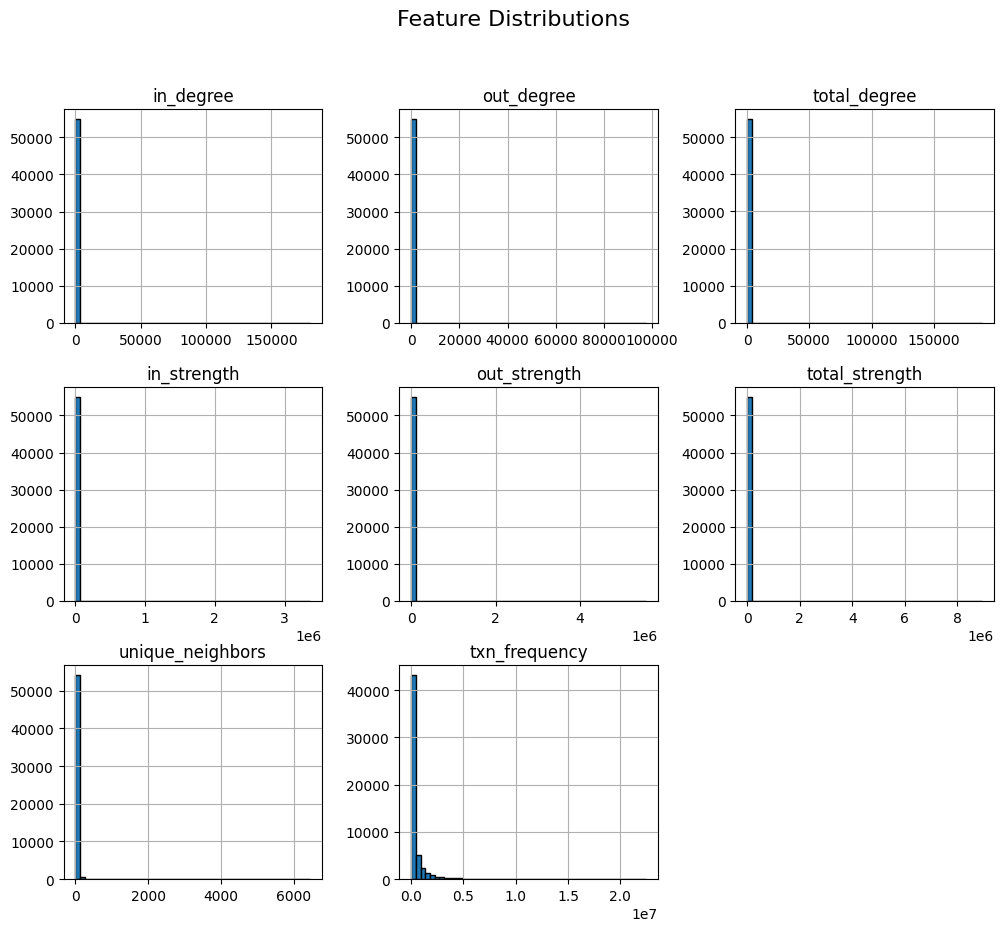

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
df_features.hist(bins=50, figsize=(12, 10), edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

In [11]:
import numpy as np

# Check for NaN or inf in edge weights
for u, v, key, attrs in subgraph2.edges(keys=True, data=True):
    weight = attrs.get("weight", 0)
    if np.isnan(weight) or np.isinf(weight):
        print(f"Invalid weight found: {weight} for edge ({u}, {v}, {key})")

In [12]:
for u, v, key, attrs in subgraph2.edges(keys=True, data=True):
    if attrs.get("weight", 0) == 0:
        subgraph2[u][v][key]["weight"] = 1e-5  # Assign a small non-zero value

In [13]:
from torch_geometric.data import Data

# Map node IDs (addresses) to numerical indices
node_mapping = {node: i for i, node in enumerate(subgraph2.nodes())}

# Extract edges with numerical indices
edge_index = []
edge_attr = []

for u, v, key, data in subgraph2.edges(keys=True, data=True):
    edge_index.append([node_mapping[u], node_mapping[v]])  # Convert to numerical indices
    edge_attr.append([data.get("amount", 0), data.get("timestamp", 0)])  # Edge features

# Convert to PyTorch tensors
edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.long)  # Transpose for PyG format
edge_attr = torch.tensor(edge_attr, dtype=torch.float)

# Convert node features (normalize first)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_features_normalized = pd.DataFrame(
    scaler.fit_transform(df_features),
    index=df_features.index,
    columns=df_features.columns
)

# Ensure the node feature order matches the numerical indices
df_features_normalized = df_features_normalized.loc[list(node_mapping.keys())]

# Convert node features to tensor
node_features_tensor = torch.tensor(df_features_normalized.values, dtype=torch.float)

# Create PyG Data object
data = Data(x=node_features_tensor, edge_index=edge_index, edge_attr=edge_attr)

print(data)

Data(x=[54911, 8], edge_index=[2, 1721354], edge_attr=[1721354, 2])


In [14]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)  # Move the entire data object to GPU

# Feature Extraction

GCN

In [15]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import VGAE

# Define GCN Encoder for GAE
class GCNEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, embedding_dim)  # Outputs embeddings

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x  # Node embeddings
class GAE(torch.nn.Module):
    def __init__(self, encoder):
        super(GAE, self).__init__()
        self.encoder = encoder

    def decode(self, z, edge_index):
        """Inner-product decoder"""
        src, dst = edge_index
        return torch.sigmoid((z[src] * z[dst]).sum(dim=1))  # Compute similarity

    def forward(self, data):
        z = self.encoder(data.x, data.edge_index)  # Generate embeddings
        return z
def get_link_labels(pos_edge_index, neg_edge_index):
    """Creates labels: 1 for existing edges, 0 for randomly sampled negative edges"""
    pos_labels = torch.ones(pos_edge_index.size(1))
    neg_labels = torch.zeros(neg_edge_index.size(1))
    return torch.cat([pos_labels, neg_labels], dim=0)

# Negative sampling: Randomly pick node pairs that are not connected
import random

def sample_negative_edges(num_nodes, num_samples, existing_edges):
    neg_edges = set()
    while len(neg_edges) < num_samples:
        u, v = random.randint(0, num_nodes - 1), random.randint(0, num_nodes - 1)
        if (u, v) not in existing_edges and (v, u) not in existing_edges:
            neg_edges.add((u, v))
    return torch.tensor(list(neg_edges)).t()

# Prepare negative edges
num_neg_samples = data.edge_index.size(1)
neg_edge_index = sample_negative_edges(data.num_nodes, num_neg_samples, set(map(tuple, data.edge_index.t().tolist())))
# Initialize GAE model
encoder = GCNEncoder(input_dim=data.x.shape[1], hidden_dim=64, embedding_dim=128)
model = GAE(encoder).to(device)

# Optimizer & Loss Function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    z = model(data.to(device))

    pos_preds = model.decode(z, data.edge_index)
    neg_preds = model.decode(z, neg_edge_index)

    preds = torch.cat([pos_preds, neg_preds], dim=0)
    labels = get_link_labels(data.edge_index, neg_edge_index).to(device)

    loss = F.binary_cross_entropy(preds, labels)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

gcn_embeddings = model(data.to(device))
print("GCN Embeddings Shape:", gcn_embeddings.shape)

Epoch 0, Loss: 12.9796
Epoch 10, Loss: 3.6659
Epoch 20, Loss: 2.6910
Epoch 30, Loss: 1.5507
Epoch 40, Loss: 0.7358
Epoch 50, Loss: 0.6085
Epoch 60, Loss: 0.7366
Epoch 70, Loss: 0.5964
Epoch 80, Loss: 0.5331
Epoch 90, Loss: 0.4963
GCN Embeddings Shape: torch.Size([54911, 128])


Node2Vec

In [16]:
from torch_geometric.nn import Node2Vec
import torch

# Move graph to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define Node2Vec model
node2vec = Node2Vec(
    edge_index=data.edge_index,  # Edge list
    embedding_dim=128,          # Embedding dimensionality
    walk_length=20,             # Length of random walks
    context_size=10,            # Context size for training
    walks_per_node=10,          # Number of walks per node
    num_negative_samples=1,     # Number of negative samples
    sparse=True                 # Use sparse embeddings for memory efficiency
).to(device)

# Train the model
loader = node2vec.loader(batch_size=128, shuffle=True, num_workers=4)  # Data loader
optimizer = torch.optim.SparseAdam(node2vec.parameters(), lr=0.01)           # Optimizer

def train():
    node2vec.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = node2vec.loss(pos_rw.to(device), neg_rw.to(device))  # Compute loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Train for multiple epochs
for epoch in range(1, 20):
    loss = train()
    print(f"Epoch: {epoch:02d}, Loss: {loss:.4f}")

# Get embeddings for all nodes
node2vec_embeddings = node2vec(torch.arange(data.num_nodes, device=device))
print("Node embeddings shape:", node2vec_embeddings.shape)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 01, Loss: 4.3088
Epoch: 02, Loss: 1.9410
Epoch: 03, Loss: 1.1405
Epoch: 04, Loss: 0.8900
Epoch: 05, Loss: 0.8087
Epoch: 06, Loss: 0.7736
Epoch: 07, Loss: 0.7549
Epoch: 08, Loss: 0.7441
Epoch: 09, Loss: 0.7375
Epoch: 10, Loss: 0.7332
Epoch: 11, Loss: 0.7302
Epoch: 12, Loss: 0.7282
Epoch: 13, Loss: 0.7267
Epoch: 14, Loss: 0.7258
Epoch: 15, Loss: 0.7251
Epoch: 16, Loss: 0.7249
Epoch: 17, Loss: 0.7248
Epoch: 18, Loss: 0.7250
Epoch: 19, Loss: 0.7252
Node embeddings shape: torch.Size([54911, 128])


# Classification

In [17]:
# Extract fraud labels from nodes (default to 0 if missing)
y_labels = torch.tensor(
    [subgraph2.nodes[node].get("isp", 0) for node in subgraph2.nodes()],
    dtype=torch.long  # Classification labels should be long dtype
)

# Add labels to PyG Data object
data = Data(x=node_features_tensor, edge_index=edge_index, edge_attr=edge_attr, y=y_labels)
data = data.to(device)  # Move the entire data object to GPU
print(data)

Data(x=[54911, 8], edge_index=[2, 1721354], edge_attr=[1721354, 2], y=[54911])


In [23]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report, accuracy_score, precision_score, recall_score, f1_score

def train_xgboost(X_final, y_final):
    X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2,
                                                            stratify=y_final, random_state=42)
    xgb_clf = xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        scale_pos_weight=(sum(y_train == 0) / sum(y_train == 1)),
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='hist',
        device='cuda:0'
    )
    xgb_clf.fit(X_train, y_train)
    evaluate_model(xgb_clf, X_test, y_test, "XGBoost")

def train_random_forest(X_final, y_final):
    X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2,
                                                            stratify=y_final, random_state=42)
    rf_clf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
    rf_clf.fit(X_train, y_train)
    evaluate_model(rf_clf, X_test, y_test, "Random Forest")

def train_svm(X_final, y_final):
    X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2,
                                                            stratify=y_final, random_state=42)
    svm_clf = SVC(kernel="rbf", class_weight="balanced", probability=True)
    svm_clf.fit(X_train, y_train)
    evaluate_model(svm_clf, X_test, y_test, "SVM")

def evaluate_model(model, X_test, y_test, name):
    # Get prediction probabilities. Use decision_function if predict_proba not available.
    if hasattr(model, 'predict_proba'):
        y_probs = model.predict_proba(X_test)[:, 1]
    else:
        y_probs = model.decision_function(X_test)
    y_pred = (y_probs >= 0.5).astype(int)

    # Compute PR-AUC and ROC-AUC metrics.
    precisions, recalls, _ = precision_recall_curve(y_test, y_probs)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    pr_auc = auc(recalls, precisions)
    roc_auc = auc(fpr, tpr)

    # Calculate evaluation metrics for both binary (positive class) and overall (macro)
    precision_bin = precision_score(y_test, y_pred, average='binary')
    recall_bin    = recall_score(y_test, y_pred, average='binary')
    f1_bin        = f1_score(y_test, y_pred, average='binary')

    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_macro    = recall_score(y_test, y_pred, average='macro')
    f1_macro        = f1_score(y_test, y_pred, average='macro')
    accuracy        = accuracy_score(y_test, y_pred)

    print(f"Final Test Set Evaluation - {name}:")
    print(classification_report(y_test, y_pred))
    print("Additional Metrics:")
    print(f"  Binary - Precision: {precision_bin:.4f}, Recall: {recall_bin:.4f}, F1-Score: {f1_bin:.4f}")
    print(f"  Overall (Macro) - Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1-Score: {f1_macro:.4f}, Accuracy: {accuracy:.4f}")
    print(f"  PR-AUC: {pr_auc:.4f}, ROC-AUC: {roc_auc:.4f}\n")

    plt.figure(figsize=(12, 5))

    # PR-AUC Curve
    plt.subplot(1, 2, 1)
    plt.plot(recalls, precisions, marker='.', label=f'PR-AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{name} - Precision-Recall Curve')
    plt.legend()

    # ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, marker='.', label=f'ROC-AUC = {roc_auc:.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} - ROC Curve')
    plt.legend()

    plt.show()

# Example usage:
# Assuming variables like gcn_embeddings, gat_embeddings, etc., and a `data` object with .x and .y attributes are defined.


===== Training models for gcn embeddings =====
Final Feature Matrix Shape: (54911, 136)
Label Distribution: (array([0, 1]), array([53746,  1165]))
Training XGBoost on gcn embeddings...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:29:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final Test Set Evaluation - XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     10750
           1       0.52      0.82      0.63       233

    accuracy                           0.98     10983
   macro avg       0.76      0.90      0.81     10983
weighted avg       0.99      0.98      0.98     10983

Additional Metrics:
  Binary - Precision: 0.5177, Recall: 0.8155, F1-Score: 0.6333
  Overall (Macro) - Precision: 0.7568, Recall: 0.8995, F1-Score: 0.8115, Accuracy: 0.9800
  PR-AUC: 0.7990, ROC-AUC: 0.9754



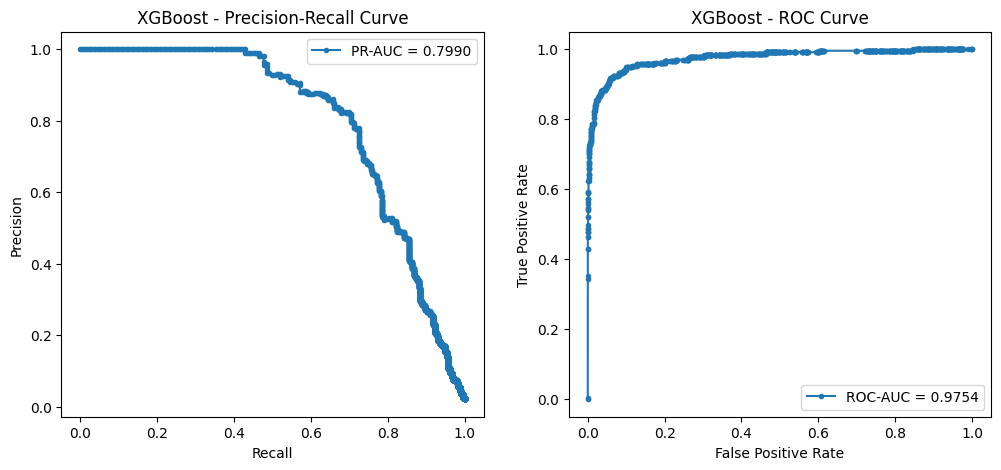

XGBoost training time for gcn embeddings: 3.42 seconds
Training Random Forest on gcn embeddings...
Final Test Set Evaluation - Random Forest:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10750
           1       0.85      0.45      0.59       233

    accuracy                           0.99     10983
   macro avg       0.92      0.73      0.79     10983
weighted avg       0.99      0.99      0.98     10983

Additional Metrics:
  Binary - Precision: 0.8480, Recall: 0.4549, F1-Score: 0.5922
  Overall (Macro) - Precision: 0.9182, Recall: 0.7266, F1-Score: 0.7927, Accuracy: 0.9867
  PR-AUC: 0.7079, ROC-AUC: 0.9676



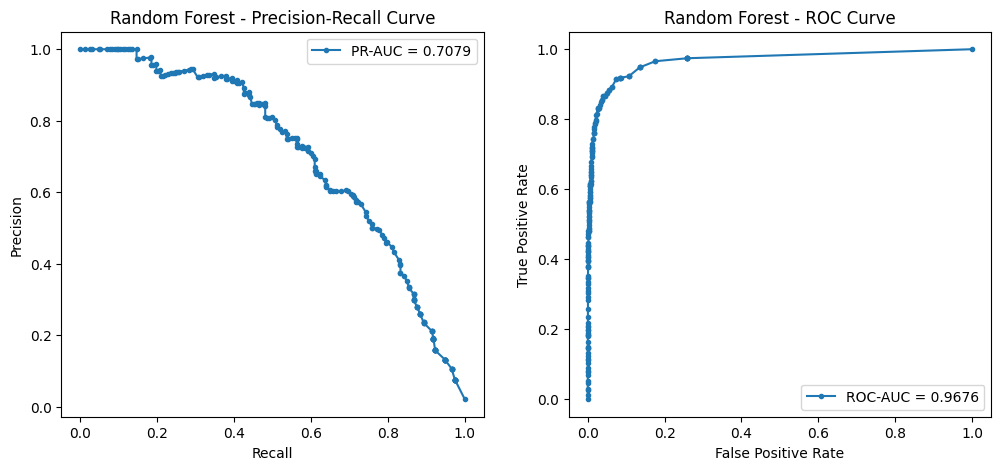

Random Forest training time for gcn embeddings: 85.81 seconds
Training SVM on gcn embeddings...
Final Test Set Evaluation - SVM:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10750
           1       0.47      0.16      0.24       233

    accuracy                           0.98     10983
   macro avg       0.73      0.58      0.61     10983
weighted avg       0.97      0.98      0.97     10983

Additional Metrics:
  Binary - Precision: 0.4684, Recall: 0.1588, F1-Score: 0.2372
  Overall (Macro) - Precision: 0.7252, Recall: 0.5774, F1-Score: 0.6131, Accuracy: 0.9783
  PR-AUC: 0.2998, ROC-AUC: 0.9065



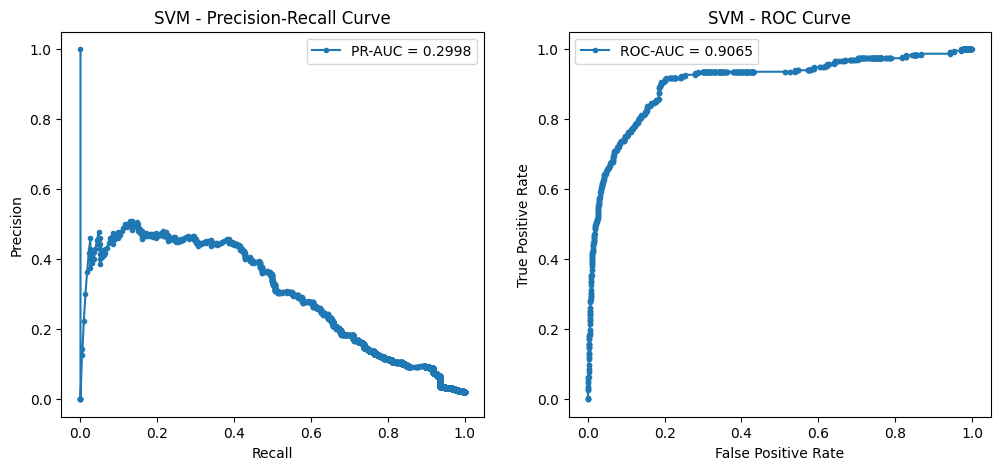

SVM training time for gcn embeddings: 1180.93 seconds

===== Training models for node2vec embeddings =====
Final Feature Matrix Shape: (54911, 136)
Label Distribution: (array([0, 1]), array([53746,  1165]))
Training XGBoost on node2vec embeddings...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:50:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final Test Set Evaluation - XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10750
           1       0.53      0.69      0.60       233

    accuracy                           0.98     10983
   macro avg       0.76      0.84      0.80     10983
weighted avg       0.98      0.98      0.98     10983

Additional Metrics:
  Binary - Precision: 0.5314, Recall: 0.6910, F1-Score: 0.6007
  Overall (Macro) - Precision: 0.7623, Recall: 0.8389, F1-Score: 0.7954, Accuracy: 0.9805
  PR-AUC: 0.6725, ROC-AUC: 0.9647



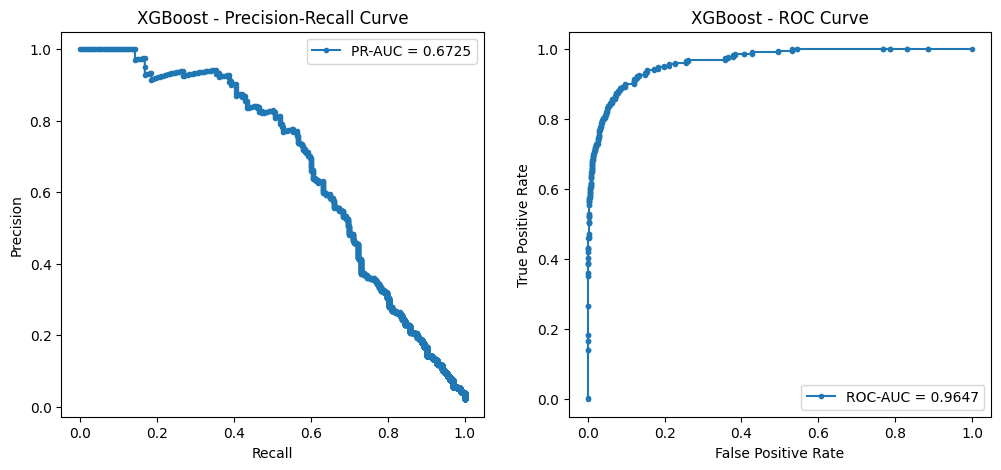

XGBoost training time for node2vec embeddings: 2.94 seconds
Training Random Forest on node2vec embeddings...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

Final Test Set Evaluation - Random Forest:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10750
           1       0.00      0.00      0.00       233

    accuracy                           0.98     10983
   macro avg       0.49      0.50      0.49     10983
weighted avg       0.96      0.98      0.97     10983

Additional Metrics:
  Binary - Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
  Overall (Macro) - Precision: 0.4894, Recall: 0.5000, F1-Score: 0.4946, Accuracy: 0.9788
  PR-AUC: 0.4458, ROC-AUC: 0.9399



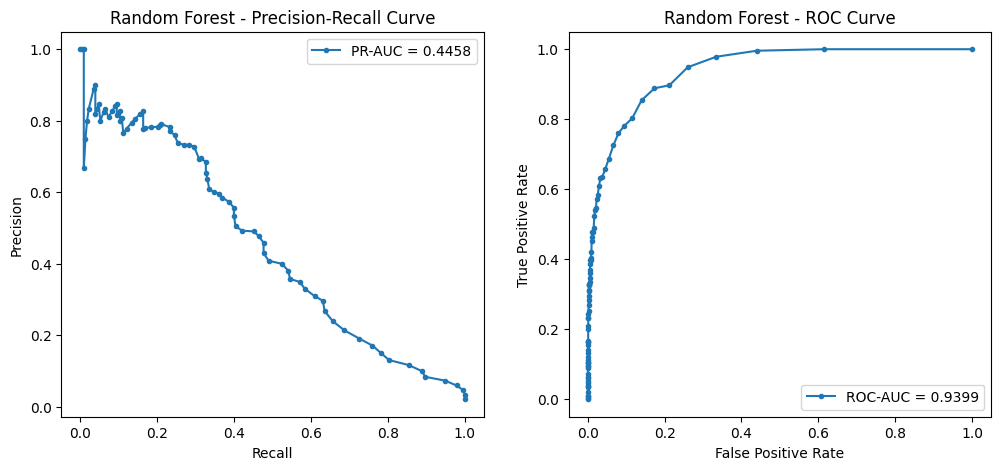

Random Forest training time for node2vec embeddings: 125.70 seconds
Training SVM on node2vec embeddings...
Final Test Set Evaluation - SVM:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10750
           1       0.43      0.07      0.12       233

    accuracy                           0.98     10983
   macro avg       0.71      0.53      0.55     10983
weighted avg       0.97      0.98      0.97     10983

Additional Metrics:
  Binary - Precision: 0.4324, Recall: 0.0687, F1-Score: 0.1185
  Overall (Macro) - Precision: 0.7063, Recall: 0.5334, F1-Score: 0.5538, Accuracy: 0.9783
  PR-AUC: 0.1817, ROC-AUC: 0.8241



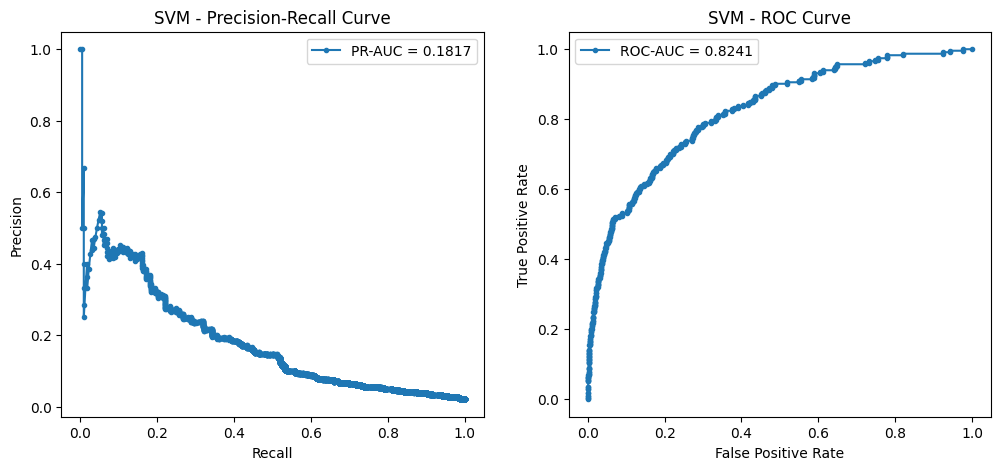

SVM training time for node2vec embeddings: 1030.75 seconds


In [24]:
import time

embeddings_dict = {
    "gcn": gcn_embeddings,
    "node2vec": node2vec_embeddings,
}

for name, embedding in embeddings_dict.items():
    print(f"\n===== Training models for {name} embeddings =====")

    # Convert PyTorch tensor to NumPy, if needed
    if isinstance(embedding, np.ndarray):
        embedding_np = embedding  # Already a NumPy array
    else:
        embedding_np = embedding.cpu().detach().numpy()  # Convert PyTorch tensor to NumPy

    # Concatenate with original features
    X_final = np.concatenate([data.x.cpu().detach().numpy(), embedding_np], axis=1)
    y_final = data.y.cpu().numpy()

    print("Final Feature Matrix Shape:", X_final.shape)  # e.g., (30857, feature_dim + 128)
    print("Label Distribution:", np.unique(y_final, return_counts=True))

    # Train XGBoost and time it
    print(f"Training XGBoost on {name} embeddings...")
    start_time = time.time()
    train_xgboost(X_final, y_final)
    elapsed = time.time() - start_time
    print(f"XGBoost training time for {name} embeddings: {elapsed:.2f} seconds")

    # Train Random Forest and time it
    print(f"Training Random Forest on {name} embeddings...")
    start_time = time.time()
    train_random_forest(X_final, y_final)
    elapsed = time.time() - start_time
    print(f"Random Forest training time for {name} embeddings: {elapsed:.2f} seconds")

    # train SVM as well
    print(f"Training SVM on {name} embeddings...")
    start_time = time.time()
    train_svm(X_final, y_final)
    elapsed = time.time() - start_time
    print(f"SVM training time for {name} embeddings: {elapsed:.2f} seconds")